In [1]:
from sklearn.cluster import KMeans
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline
import json
import scipy.sparse as sparse
from collections import defaultdict
from utils import  *
#https://towardsdatascience.com/spectral-clustering-aba2640c0d5b

In [2]:
def makeCircleGraph():
    G=nx.Graph()
    G.add_edge(0,1)
    G.add_edge(0,2)
    G.add_edge(0,5)
    G.add_edge(0,8)
    G.add_edge(0,9)
    G.add_edge(1,2)
    G.add_edge(3,4)
    G.add_edge(3,5)
    G.add_edge(4,5)
    G.add_edge(5,6)
    G.add_edge(5,7)
    G.add_edge(6,7)
    G.add_edge(8,9)
    return G
def makeGraph2():
    G=nx.Graph()
    G.add_edge(0,1,weight=0.8)
    G.add_edge(0,2,weight=0.6)
    G.add_edge(0,3,weight=0.1)
    
    G.add_edge(1,2,weight=0.9)
    G.add_edge(2,5,weight=0.2)
    
    G.add_edge(3,4,weight=0.6)
    G.add_edge(3,5,weight=0.7)
    
    G.add_edge(4,5,weight=0.8)
    return G
def drawGraph(G,cluster=None,lineWidth=3,node_size=500,seed=None,minLine=1,maxLine=6,drawLabel=False,drawAllNode=False,
             highlight_node=[]):
    '''
    G:图对象
    cluster:对定点的分类结果,cluser[nodeId]表示类别
        cluster不是空,只有相同类型顶点之间才会画上边
    
    '''
    
    
    pos = nx.spring_layout(G,seed=seed)  # positions for all nodes
    colors=['#ff6666','#B03060','#EEAD0E','#ccff00','#8B7500','#912CEE','#B03060','#8B7500','#912CEE','#B03060',
            '#B03060','#cc0066','#99ff66','#990033','#666633',
            '#660099','#EEAD0E','#D1EEEE','#48D1CC','#030303','#8B0000',
            '#8B7500','#912CEE','#B03060']
    plt.figure(figsize=(10, 10))
    #有边长的
    nodelist=set([nodeId for nodeId,adj in G.adjacency() if len(adj)>0])
    
    if cluster is not None:
        groups=defaultdict(list)
        #draw node
        for node in G.nodes:
            if not drawAllNode:
                if node not in nodelist:continue
            c=cluster[node]
            nx.draw_networkx_nodes(G,pos,nodelist=[node],node_color=colors[c],node_size=node_size,alpha=0.8)
        #draw edge
        for u,v,_ in G.edges(data=True):
            if cluster[u]==cluster[v]:
                groups[cluster[u]].append((u,v))
        for c,edgelist in groups.items():
            nx.draw_networkx_edges(G,pos,edgelist,width=lineWidth,edge_color=colors[c],alpha=0.5)
        #画群的标注
        K=np.max(labels)+1
        for i in range(K):
            plt.plot([], marker='x', label='C:'+str(i),c=colors[i])
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    else:
        if not drawAllNode:
            nx.draw_networkx_nodes(G, pos,nodelist=nodelist,node_size=node_size,alpha=0.8)
        else:
            nx.draw_networkx_nodes(G, pos,node_size=node_size,alpha=0.8)
        if len(highlight_node)>0:
            nx.draw_networkx_nodes(G, pos,nodelist=highlight_node,node_color='r',
                                   node_size=int(node_size*1.5),alpha=0.8)
        #求出最小权重与最大权重
        minW,maxW=float('inf'),-1
        for u,v,d in G.edges(data=True):
            d=d['weight'] if 'weight' in d else 1.0
            if d>maxW:
                maxW=d
            if d<minW:
                minW=d
        #  线宽正比于权重
        for u,v,d in G.edges(data=True):
            d=d['weight'] if 'weight' in d else 1.0
            if minW==maxW:
                linesize=minLine
            else:
                linesize=minLine+maxLine*(d-minW)/(minW-maxW)
            nx.draw_networkx_edges(G,pos,[(u,v)],alpha=0.4,width=linesize)
    # labels
    if drawLabel:
        nx.draw_networkx_labels(G, pos, font_size=20, font_family='sans-serif')
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.axis('off')
    plt.show()
    return pos

 
## 正式测试

#全部节点数量,有临边节点数量,#边数量(双向): 354 354 1399
(354,)
(354, 354)
classes: 7


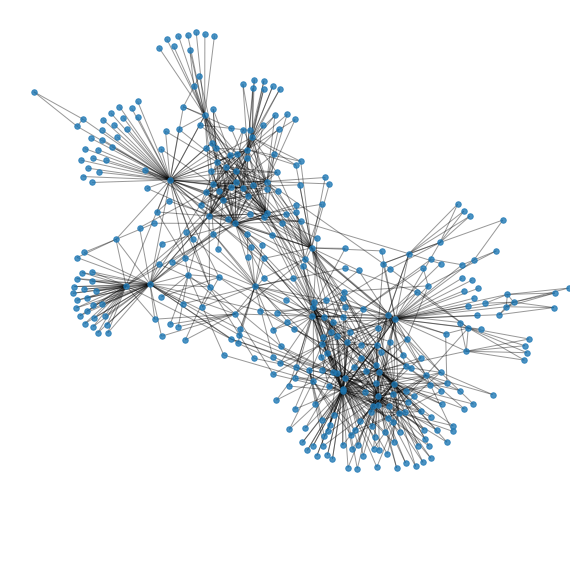

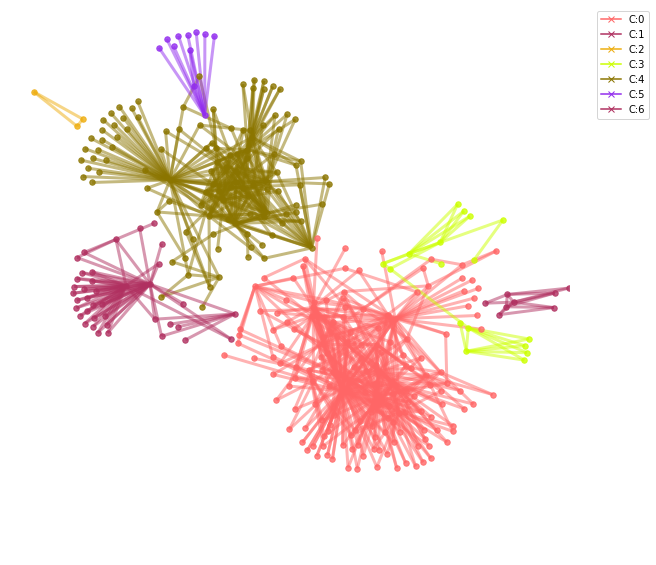

In [6]:
seed=0

G,Id2Index,Index2Id,_=makeChengfGraph('15644550955586.json')
# G,Id2Index,Index2Id,_=makeChengfGraph('data/111111111111111111.json')
# G = nx.random_geometric_graph(1000, 0.125)
GA=graph2Matrix(G,norm=False)
L=LaplacianMatrix(GA)
S,V=eig(L,maxK=30,maxTry=10,supportDim=300)

print(S.shape)
print(V.shape)
K=proposalCluster(S,0.7)
print('classes:',K)

labels=getCluster(K,V)
plt.figure()
pos=drawGraph(G,cluster=None,node_size=30,seed=seed)
pos=drawGraph(G,labels,lineWidth=3,seed=seed,node_size=30)

In [5]:
print(S)

[1.39522725e-15 2.77920082e-01 4.86081723e-01 5.13068200e-01
 5.42275835e-01 6.46944827e-01 6.67832471e-01 7.30418813e-01
 7.45164031e-01 8.08691741e-01 8.82068629e-01 9.66067263e-01
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.07951475e+00 1.11464365e+00 1.14635300e+00 1.20021570e+00
 1.25288338e+00 1.29356038e+00 1.30679558e+00 1.31743247e+00
 1.34547025e+00 1.36701047e+00 1.37330168e+00 1.37794527e+00
 1.41795297e+00 1.45165642e+00 1.47935582e+00 1.50436028e+00
 1.51088282e+00 1.548490

### 话单数据

#全部节点数量,有临边节点数量,#边数量(双向): 354 354 1399


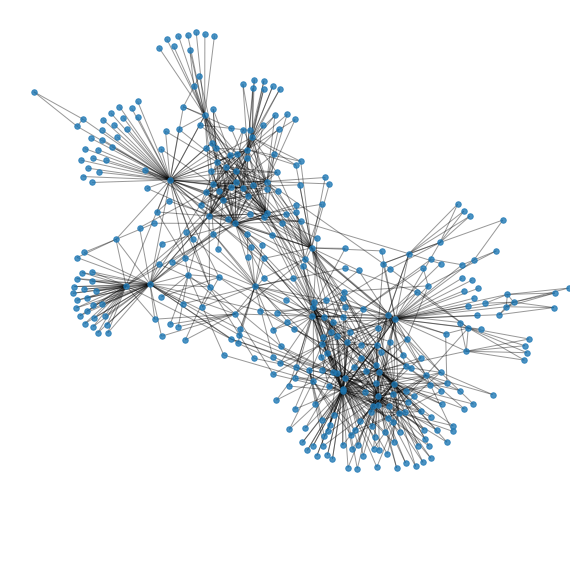

In [7]:
seed=0

G,Id2Index,Index2Id,_=makeChengfGraph('15644550955586.json')
pos=drawGraph(G,cluster=None,node_size=30,seed=seed)

classes: 9


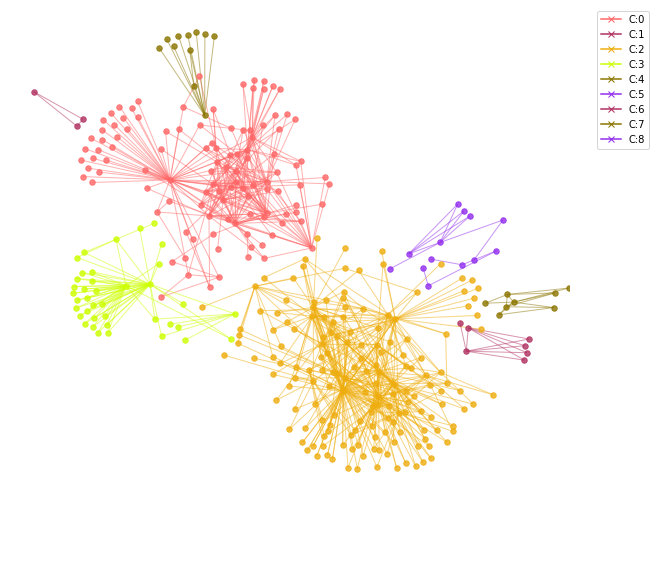

In [24]:
L=LaplacianMatrix(graph2Matrix(G,norm=False))
S,V=eig(L)
K=proposalCluster(S,0.8)
print('classes:',K)
labels=getCluster(K,V)
pos=drawGraph(G,labels,lineWidth=1,node_size=30,seed=seed)

### 根据分类提取出子图,然后可以对子图进行rank

In [25]:
subgraphs=get_subGraph(G,labels)

聚类:0,节点数量:111,边数量(无向):310
聚类:1,节点数量:3,边数量(无向):4
聚类:2,节点数量:162,边数量(无向):460
聚类:3,节点数量:39,边数量(无向):69
聚类:4,节点数量:8,边数量(无向):16
聚类:5,节点数量:5,边数量(无向):5
聚类:6,节点数量:7,边数量(无向):11
聚类:7,节点数量:11,边数量(无向):11
聚类:8,节点数量:8,边数量(无向):12


In [26]:
Index2Id={x:x for x in G.nodes}

In [28]:
cluster_rank=SubGraphPageRank(subgraphs,
                              global_name_fn=Index2Id,
                              topK=-1,alpha=0.85,maxiters=300,eps=0.01)
cluster_rank

使用稀疏表示法
使用稀疏表示法
使用稀疏表示法


{0: {'top': [32,
   223,
   17,
   91,
   305,
   163,
   170,
   71,
   238,
   156,
   34,
   124,
   179,
   350,
   234,
   175,
   291,
   283,
   56,
   102,
   149,
   284,
   150,
   98,
   319,
   85,
   215,
   286,
   327,
   281,
   28,
   336,
   9,
   328,
   55,
   275,
   250,
   244,
   196,
   136,
   49,
   333,
   225,
   227,
   220,
   7,
   23,
   139,
   18,
   269,
   143,
   154,
   292,
   349,
   218,
   161,
   22,
   122,
   77,
   261,
   41,
   326,
   246,
   46,
   254,
   75,
   59,
   164,
   198,
   341,
   206,
   8,
   72,
   130,
   80,
   11,
   338,
   192,
   293,
   171,
   134,
   191,
   282,
   58,
   24,
   272,
   266,
   48,
   52,
   248,
   310,
   233,
   267,
   259,
   318,
   111,
   204,
   101,
   93,
   274,
   73,
   347,
   140,
   176,
   147,
   297,
   39,
   117,
   121,
   127,
   280],
  'top_index': [32,
   223,
   17,
   91,
   305,
   163,
   170,
   71,
   238,
   156,
   34,
   124,
   179,
   350,
   234,
   175,


In [17]:
##显示子图,然后观测子图的rank

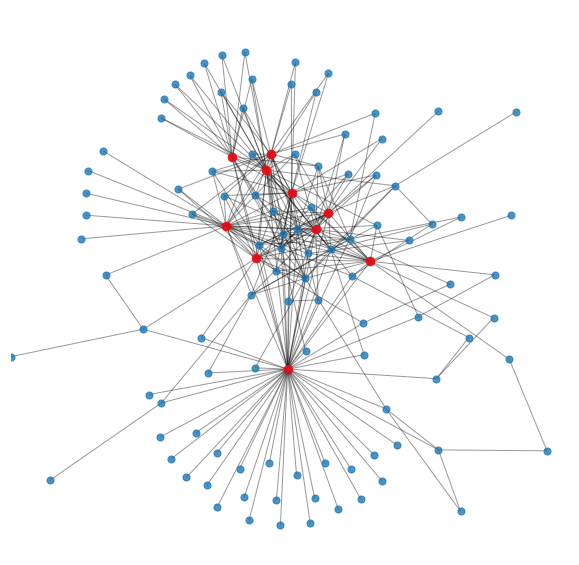

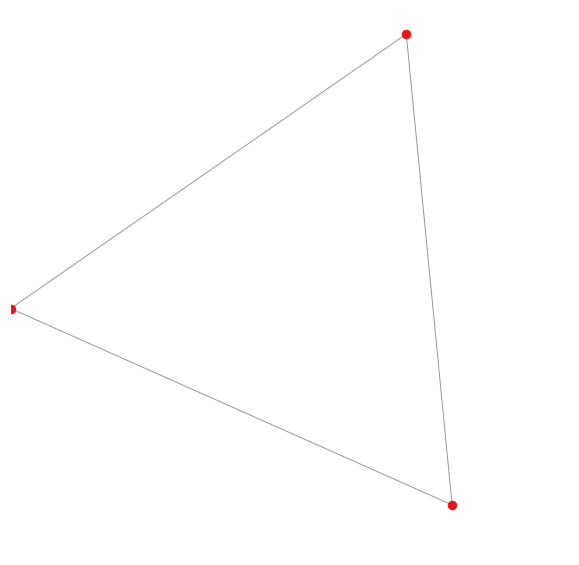

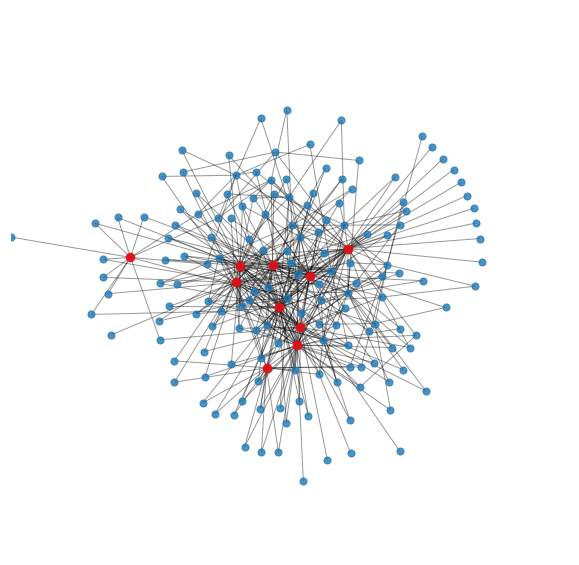

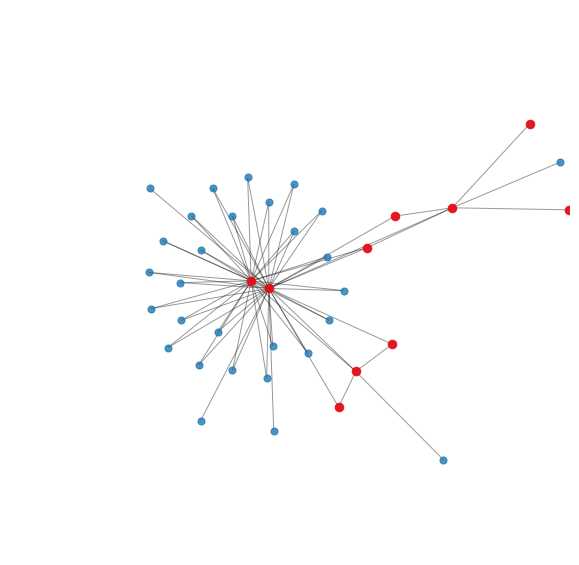

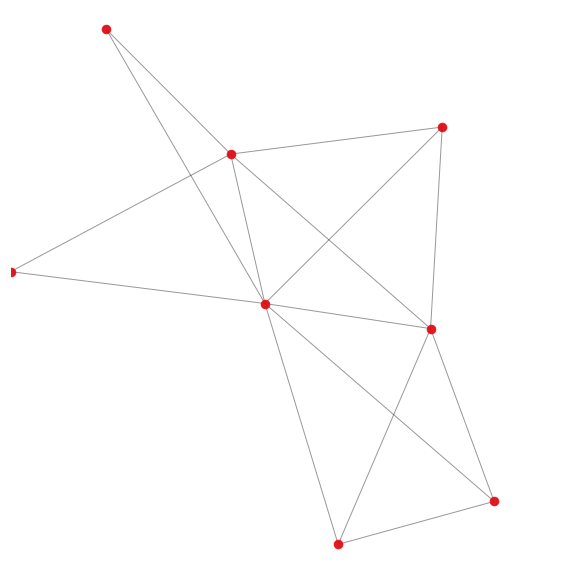

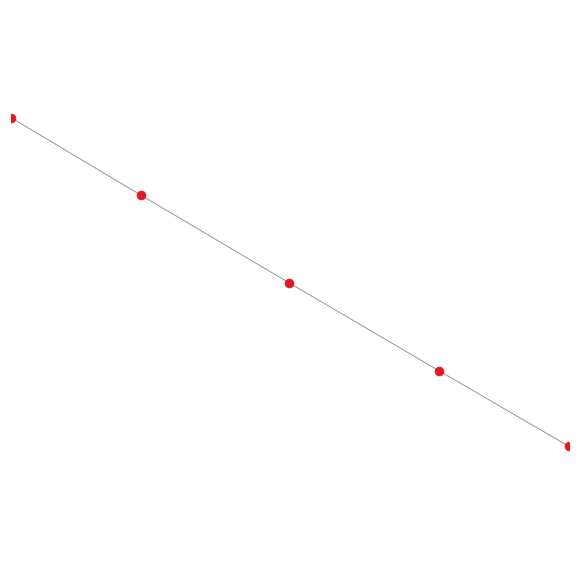

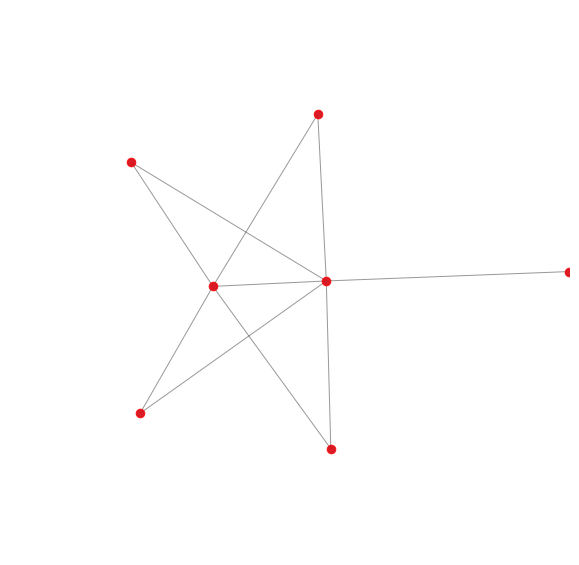

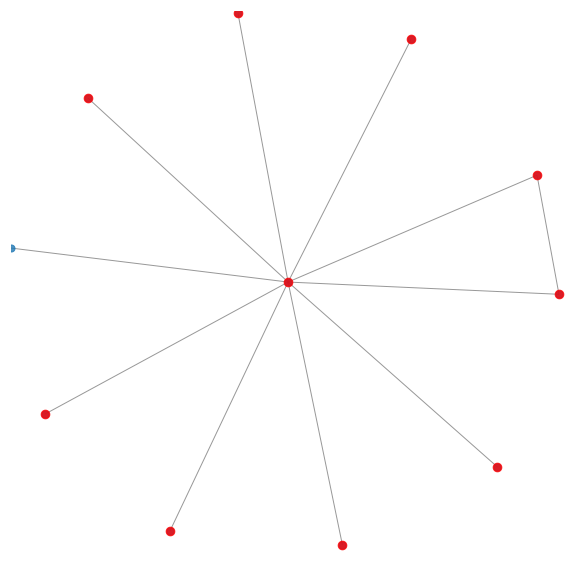

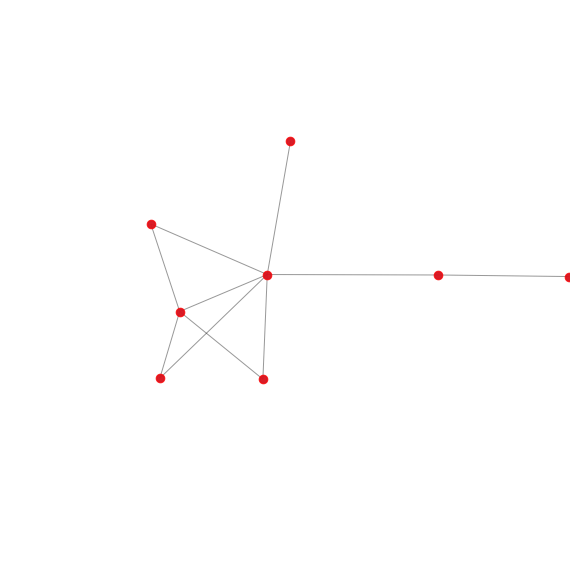

In [29]:
for clusterId in range(K):
    g=subgraphs[clusterId]['graph']
    highlight_node=cluster_rank[clusterId]['top_index'][:10]
    g_pos=drawGraph(g,node_size=50,seed=seed,highlight_node=highlight_node)